In [32]:
import math
import torch
import random

## Perceptron wielowarstwowy

Zaimplementujmy prostą sieć neuronową, opierając się z grubsza na sposobie, w jaki są one implementowane w bibliotece PyTorch.

In [33]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [34]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

Podstawowym elementem budowy sieci neuronowej jest *neuron*.

![](img/neuron_model.jpeg)

In [35]:
class Neuron:


    def __init__(self, nin):
        """
        Konstruktor losowo inicjalizuje wagi i bias neuronu

        :param nin: liczba wejść do neuronu (wymiar wektora wejściowego)
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    # forward pass
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

Sieć neuronowa składa się z warstw, a każda z nich składa się z neuronów.

<div>
<img src="img/nn.png" width="650"/>
</div>



In [36]:
class Layer:

    def __init__(self, nin, nout):
        """

        :param nin: liczba wejść do pojedynczego neuronu w warstwie
        :param nout: liczba neuronów w warstwie (inaczej mówiąc liczba wyjść z warstwy)
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # w ostatniej warstwie zwróć Value (zamiast listy)
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

Na koniec połączmy warstwy, aby utworzyć sieć neuronową.

In [37]:
class MLP:

    def __init__(self, nin, nouts):
        """

        :param nin: długość wektora wejściowego do sieci
        :param nouts: lista przechowująca wymiary poszczególnych warstw sieci
        """
        sz = [nin] + nouts
        # każda kolejna warstwa będzie miała tyle wejść ile poprzednia wyjść
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Utwórzmy sieć z powyżej zamieszczonego obrazka.

In [38]:
x = [1.0, 2.0, 3.0]
nn = MLP(3, [4, 4, 1])
nn(x)

Value(data=-0.36517861344389985)

### Przykład uczenia

Otrzymaliśmy poniższy zbiór danych oraz wyjścia, jakie sieć powinna zwrócić dla każdego z nich. Zadanie polega na nauczeniu sieci, aby zwracała poprawne wartości wyjściowe.

In [39]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # wartości docelowe

# wypróbujmy sieć na losowych wagach
y_pred = [nn(x) for x in xs]
y_pred

[Value(data=-0.6407392201288498),
 Value(data=-0.5293515357135199),
 Value(data=-0.4543164490265253),
 Value(data=-0.7027909278916241)]

Wartości zwrócone przez nienauczoną sieć są dalekie od oczekiwanych wyników. W jaki sposób dopasować wartości wag, aby poprawić jakość sieci? Z pomocą przychodzi funkcja straty (ang. *loss function*), która zwraca pojedynczą wartość określającą aktualną jakość nauczenia się sieci. Funkcją, którą posłużymy się w tym przykładzie, jest *błąd średniokwadratowy* (ang. *mean square error*).

$$MSE = $\frac{1}{n} \[ \sum_{i=1}^{n} (Y_i - \hat{Y_i})^{2}\]$$

Wartość różnicy pomiędzy $(Y_i - \hat{Y_i})$ będzie równa $0$ tylko, gdy wartości są sobie równe.

In [40]:
[(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)]

[Value(data=2.6920251884690263),
 Value(data=0.22150997693522215),
 Value(data=0.2977705378030208),
 Value(data=2.8994969441100187)]

Celem jest **minimalizacja** funkcji straty, gdyż kiedy strata jest niska bądź bliska zeru, wtedy predykcje sieci są równe swoim celom.

In [41]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
loss

Value(data=6.110802647317287)

Wykonując *backward* na zmiennej *loss*, wyznaczamy wartości gradientów dla wszystkich wag sieci neuronowej. Następnie wartości gradientów zostaną wykorzystane w aktualizacji wag neuronów w kierunku minimalizacji wartości straty.

In [42]:
loss.backward()

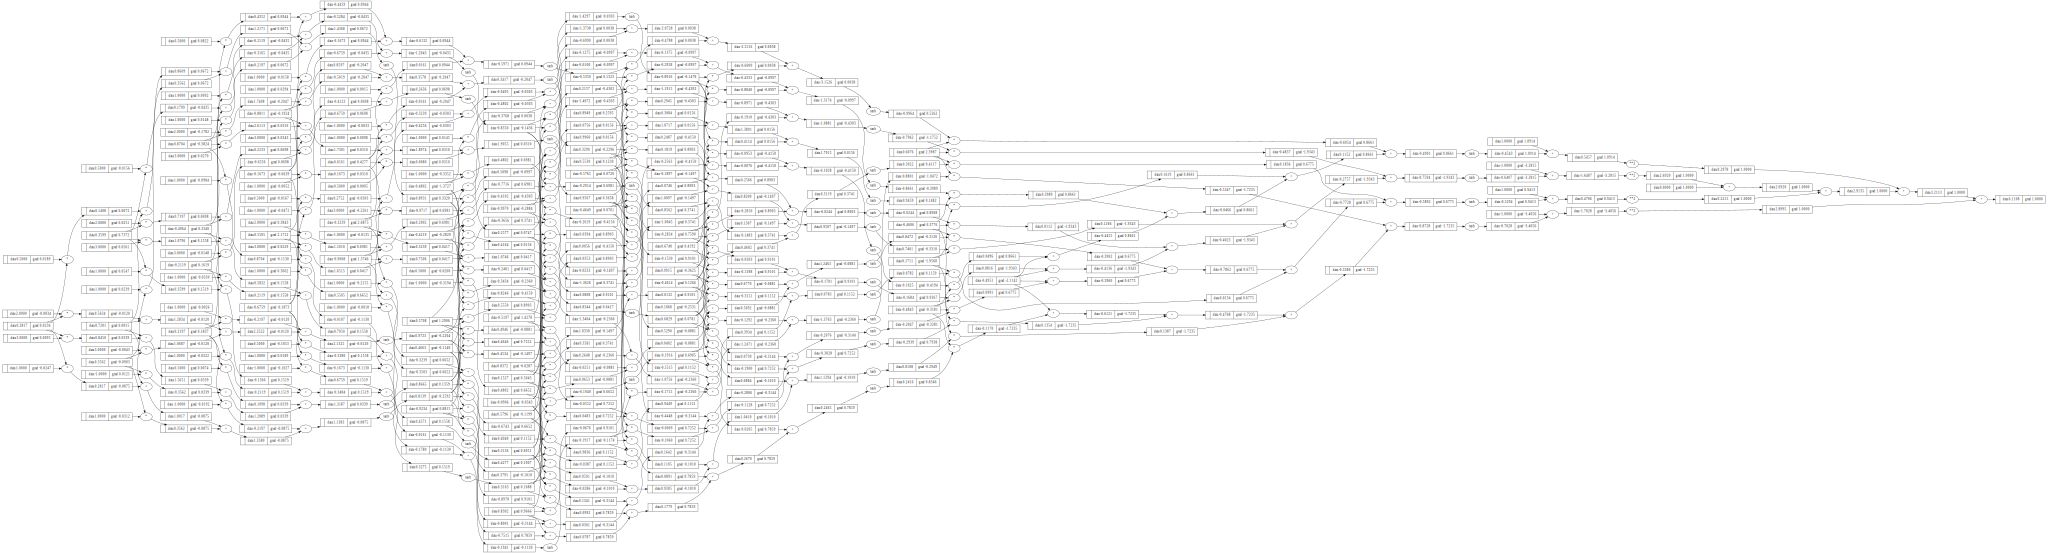

In [43]:
draw_dot(loss)

Łącząc wszystkie informacje razem, naszym celem jest aktualizacja wartości wag o mały ktok, w kierunku gradientów.  Metodę tę nazywamy *metodą gradientu prostego* (ang. *gradient descent*).

In [46]:
for k in range(20):

    # forward pass
    y_pred = [nn(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))

    # backward pass
    # wyzerowanie wartości gradientów przed kolejną aktualizacją
    for p in nn.parameters():
        p.grad = 0.0
    loss.backward()

    # aktualizacja w kierunku gradientów
    # krok = 0.1, za duża wartość kroku może spowodować 'przeskoczenie minimum funkcji'
    for p in nn.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.043116665972257065
1 0.03994382161857068
2 0.03717345792380305
3 0.03473548057351761
4 0.03257497363058191
5 0.03064833368977485
6 0.028920522167325054
7 0.027363077132738004
8 0.025952651444569912
9 0.024669922144154758
10 0.023498766004246045
11 0.022425628712607917
12 0.021439036839333844
13 0.020529216400737745
14 0.019687791916237436
15 0.01890754689117862
16 0.018182231635888717
17 0.017506407896575905
18 0.01687532235760648
19 0.016284802967870736


In [49]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
loss

Value(data=0.016284802967870736)